In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display
from scipy.signal import stft
import os
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Task A

## 1. UrbanSound8k dataset

In [2]:
df = pd.read_csv("../input/urbansound8k/UrbanSound8K.csv")
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [3]:
# Only keeping the necessary columns
df = df[['slice_file_name', 'fold', 'classID']]

## 2. Implementing Hann Window, Hamming Window, Rectangular Window

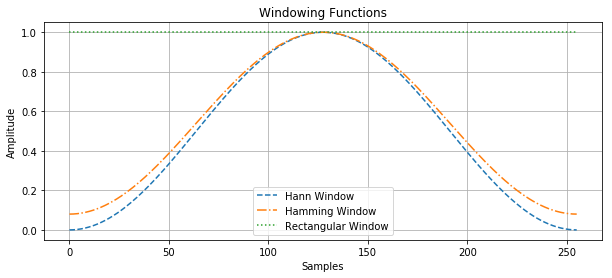

In [4]:
# Window length
N = 256

hann_window = np.hanning(N)
hamming_window = np.hamming(N)
rectangular_window = np.ones(N)

plt.figure(figsize=(10, 4))

plt.plot(hann_window, label="Hann Window", linestyle="--")
plt.plot(hamming_window, label="Hamming Window", linestyle="-.")
plt.plot(rectangular_window, label="Rectangular Window", linestyle=":")

plt.title("Windowing Functions")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

## 3. Python program to apply the above windowing techniques → Generate spectrograms using the Short-Time Fourier Transform (STFT)

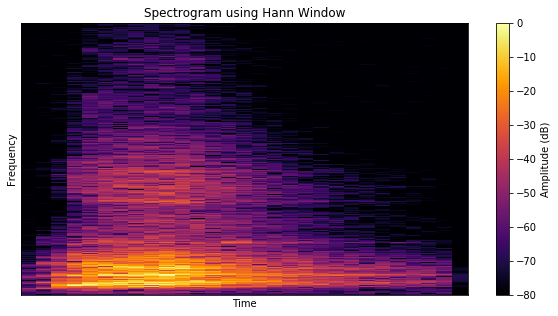

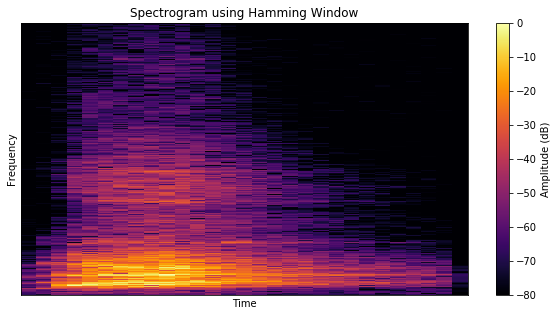

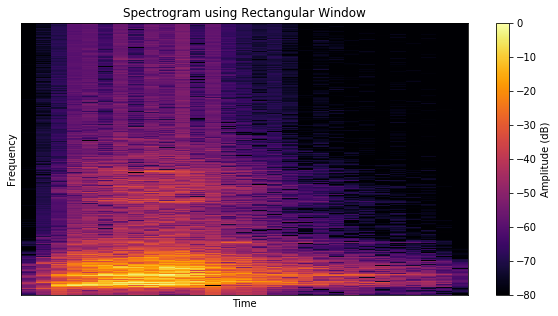

In [5]:
# Example audio file to visualise the effect of the 3 windows
audio_path = '../input/urbansound8k/fold5/100032-3-0-0.wav'
y, sr = librosa.load(audio_path, sr=None)

n_fft = 1024  # FFT window size
hop_length = 512  # Hop length (stride)
win_length = n_fft  # Window length same as n_fft

hann_window = np.hanning(win_length)
hamming_window = np.hamming(win_length)
rectangular_window = np.ones(win_length)

_, _, Zxx_hann = stft(y, fs=sr, window=hann_window, nperseg=win_length, noverlap=hop_length)
_, _, Zxx_hamming = stft(y, fs=sr, window=hamming_window, nperseg=win_length, noverlap=hop_length)
_, _, Zxx_rect = stft(y, fs=sr, window=rectangular_window, nperseg=win_length, noverlap=hop_length)

# Convert to dB scale
S_hann = librosa.amplitude_to_db(np.abs(Zxx_hann), ref=np.max)
S_hamming = librosa.amplitude_to_db(np.abs(Zxx_hamming), ref=np.max)
S_rect = librosa.amplitude_to_db(np.abs(Zxx_rect), ref=np.max)

def plot_spectrogram(S, sr, hop_length, title):
    plt.figure(figsize=(10, 5))
    librosa.display.specshow(S, sr=sr, hop_length=hop_length, cmap='inferno')
    plt.colorbar(label='Amplitude (dB)')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.show()

plot_spectrogram(S_hann, sr, hop_length, "Spectrogram using Hann Window")
plot_spectrogram(S_hamming, sr, hop_length, "Spectrogram using Hamming Window")
plot_spectrogram(S_rect, sr, hop_length, "Spectrogram using Rectangular Window")

## 4. Train a simple classifier

In [6]:
data_path = "../input/urbansound8k/"

In [7]:
df['path'] = df.apply(lambda row: os.path.join(data_path, f"fold{row['fold']}", row['slice_file_name']), axis=1)

In [30]:
def extract_features(file_path, window_type="hann", max_len=1160):
    """Extract log-mel spectrogram features with zero-padding to ensure consistent shape."""
    
    y, sr = librosa.load(file_path, sr=None)
    n_fft = 1024  # FFT window size
    hop_length = 512  # Hop length (stride)

    if window_type == "hann":
        window = np.hanning(n_fft)
    elif window_type == "hamming":
        window = np.hamming(n_fft)
    elif window_type == "rectangular":
        window = np.ones(n_fft)
    else:
        raise ValueError("Unknown window type!")

    _, _, Zxx = stft(y, fs=sr, window=window, nperseg=n_fft, noverlap=hop_length)
    
    # Convert to Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(S=np.abs(Zxx), sr=sr, n_mels=40)

    # Convert to log scale
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    feature_vector = mel_spec_db.flatten()

    # Ensure consistent feature vector length using padding and truncating if too long
    if len(feature_vector) < max_len:
        feature_vector = np.pad(feature_vector, (0, max_len - len(feature_vector)))
    else:
        feature_vector = feature_vector[:max_len]

    return feature_vector

In [31]:
# Extract features
X_hann = np.array([extract_features(f, "hann") for f in df['path']])
X_hamming = np.array([extract_features(f, "hamming") for f in df['path']])
X_rect = np.array([extract_features(f, "rectangular") for f in df['path']])

# Labels
y = np.array(df['classID'])

# Split into Train & Test (80-20 split)
X_train_hann, X_test_hann, y_train, y_test = train_test_split(X_hann, y, test_size=0.2, random_state=42)
X_train_hamming, X_test_hamming, _, _ = train_test_split(X_hamming, y, test_size=0.2, random_state=42)
X_train_rect, X_test_rect, _, _ = train_test_split(X_rect, y, test_size=0.2, random_state=42)

In [37]:
clf1 = SVC(kernel="linear")
clf1.fit(X_train_hann, y_train)
y_pred = clf1.predict(X_test_hann)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy with Hann Window: {acc:.4f}")

clf2 = SVC(kernel="linear")
clf2.fit(X_train_hamming, y_train)
y_pred = clf2.predict(X_test_hamming)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy with Hamming Window: {acc:.4f}")

clf3 = SVC(kernel="linear")
clf3.fit(X_train_rect, y_train)
y_pred = clf3.predict(X_test_rect)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy with Rectangular Window: {acc:.4f}")

Accuracy with Hann Window: 0.2788
Accuracy with Hamming Window: 0.2811
Accuracy with Rectangular Window: 0.2530


# Task B

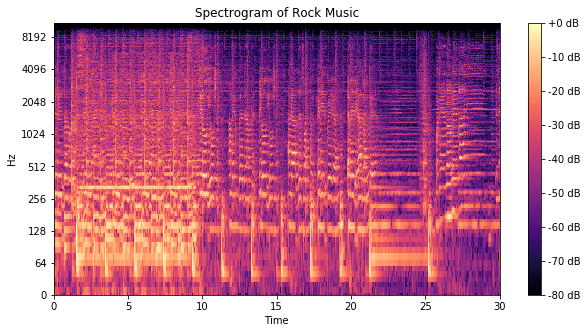

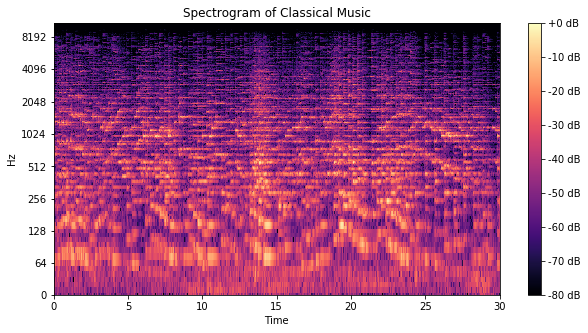

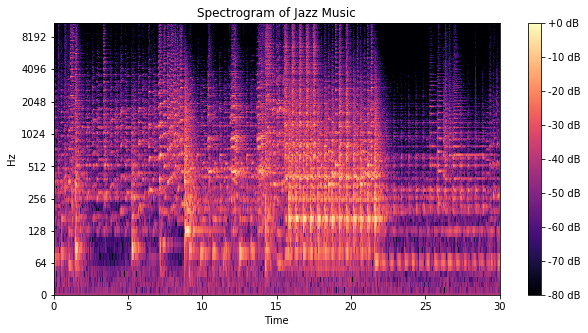

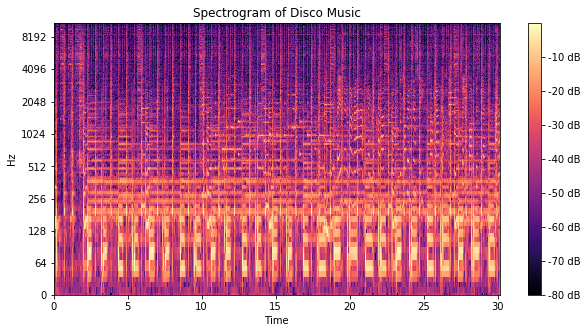

In [44]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# 4 different genres
songs = {
    "Rock": "/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/rock/rock.00000.wav",
    "Classical": "/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00000.wav",
    "Jazz": "/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00000.wav",
    "Disco": "/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/disco/disco.00000.wav"
}

def plot_spectrogram(song_path, genre):
    y, sr = librosa.load(song_path, sr=None)  # Load audio
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)  # Compute STFT

    plt.figure(figsize=(10, 5))
    librosa.display.specshow(D, sr=sr, x_axis="time", y_axis="log")
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"Spectrogram of {genre} Music")
    plt.show()

for genre, path in songs.items():
    plot_spectrogram(path, genre)
